# Module 2: Ornstein-Uhlenbeck Process and Mean Reversion

This notebook explores mean-reverting processes with real financial data, focusing on the Ornstein-Uhlenbeck (OU) process for pairs trading and statistical arbitrage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Ornstein-Uhlenbeck Process Theory

The OU process is defined by the SDE:

$$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$$

Where:
- $\theta > 0$ is the mean reversion speed
- $\mu$ is the long-term mean
- $\sigma$ is the volatility
- $W_t$ is a Wiener process

**Key Properties:**
- Mean-reverting: tends to return to $\mu$
- Stationary distribution: $N(\mu, \sigma^2/(2\theta))$
- Half-life: $t_{1/2} = \ln(2)/\theta$

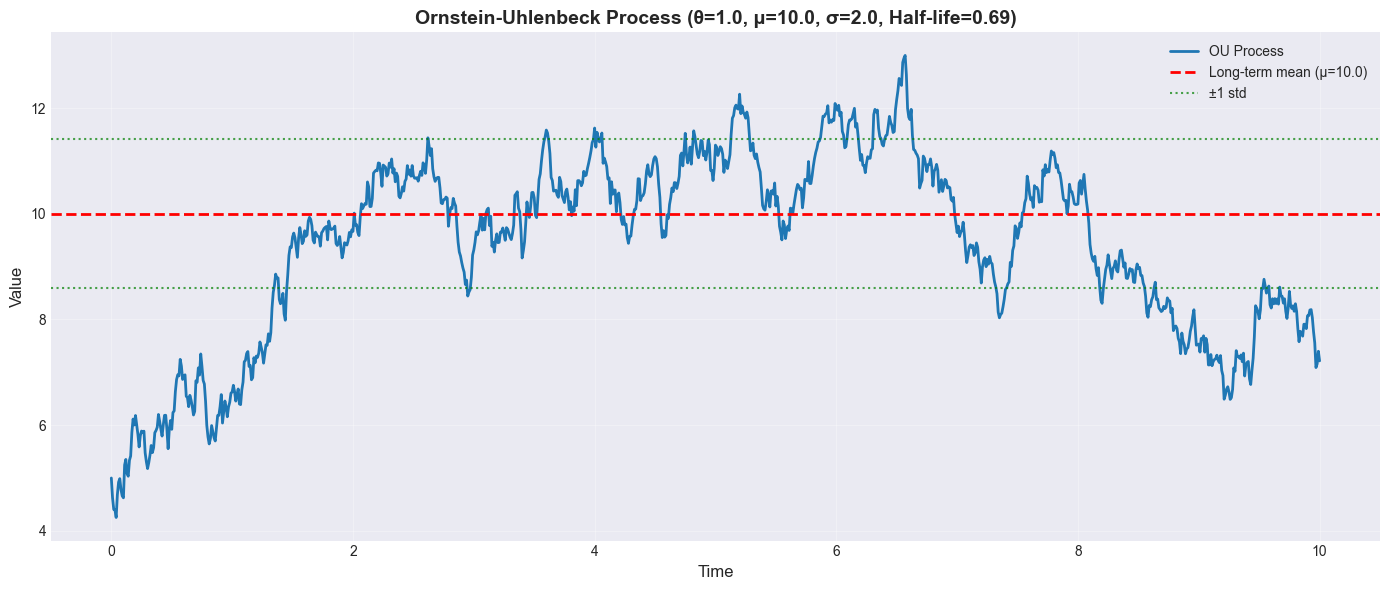

Half-life of mean reversion: 0.6931 time units
Theoretical variance: 2.0000
Empirical variance: 3.0686


In [2]:
def simulate_ou_process(theta, mu, sigma, X0, T, N):
    """
    Simulate Ornstein-Uhlenbeck process using Euler-Maruyama method.
    
    Parameters:
    -----------
    theta : float
        Mean reversion speed
    mu : float
        Long-term mean
    sigma : float
        Volatility
    X0 : float
        Initial value
    T : float
        Total time
    N : int
        Number of steps
    
    Returns:
    --------
    tuple : (t, X) time and process values
    """
    dt = T / N
    t = np.linspace(0, T, N+1)
    X = np.zeros(N+1)
    X[0] = X0
    
    for i in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i+1] = X[i] + theta * (mu - X[i]) * dt + sigma * dW
    
    return t, X

# Simulate OU process
theta = 1.0  # Mean reversion speed
mu = 10.0    # Long-term mean
sigma = 2.0  # Volatility
X0 = 5.0     # Starting below mean
T = 10.0
N = 1000

t, X = simulate_ou_process(theta, mu, sigma, X0, T, N)

# Calculate half-life
half_life = np.log(2) / theta

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(t, X, linewidth=2, label='OU Process')
ax.axhline(y=mu, color='r', linestyle='--', linewidth=2, label=f'Long-term mean (μ={mu})')
ax.axhline(y=mu + sigma/np.sqrt(2*theta), color='g', linestyle=':', alpha=0.7, label='±1 std')
ax.axhline(y=mu - sigma/np.sqrt(2*theta), color='g', linestyle=':', alpha=0.7)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title(f'Ornstein-Uhlenbeck Process (θ={theta}, μ={mu}, σ={sigma}, Half-life={half_life:.2f})', 
            fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Half-life of mean reversion: {half_life:.4f} time units")
print(f"Theoretical variance: {sigma**2 / (2*theta):.4f}")
print(f"Empirical variance: {np.var(X):.4f}")

## 2. Testing for Stationarity with Real Data

Let's test if real financial spreads exhibit mean reversion using the Augmented Dickey-Fuller test.

In [3]:
# Download pairs of related stocks
pairs = [('PEP', 'KO'), ('XOM', 'CVX'), ('JPM', 'BAC')]  # Coca-Cola/Pepsi, Oil majors, Banks

start_date = '2020-01-01'
end_date = '2024-11-01'

results = []

for stock1, stock2 in pairs:
    print(f"\nAnalyzing {stock1} vs {stock2}...")
    
    # Download data (robust handling)
    data1_df = yf.download(stock1, start=start_date, end=end_date, progress=False)
    data2_df = yf.download(stock2, start=start_date, end=end_date, progress=False)

    # If either download failed or returned no rows, skip this pair
    if data1_df is None or data2_df is None or len(data1_df) == 0 or len(data2_df) == 0:
        print(f"  Warning: No data for {stock1} or {stock2}; skipping pair.")
        continue

    # Helper to extract a close price Series safely
    def _extract_close(df_obj, ticker):
        # If DataFrame, prefer 'Close' column, else try first numeric column
        if isinstance(df_obj, pd.DataFrame):
            if 'Close' in df_obj.columns:
                s = df_obj['Close'].copy()
            else:
                # Fall back to first numeric column
                num_cols = df_obj.select_dtypes(include=[np.number]).columns
                if len(num_cols) > 0:
                    s = df_obj[num_cols[0]].copy()
                else:
                    # Last resort: use the first column
                    s = df_obj.iloc[:, 0].copy()
        elif isinstance(df_obj, pd.Series):
            s = df_obj.copy()
        else:
            # Construct a series (unlikely), but keep robust
            s = pd.Series(df_obj)
        s.name = ticker
        return s

    series1 = _extract_close(data1_df, stock1)
    series2 = _extract_close(data2_df, stock2)

    # Align dates using concat and drop missing
    df = pd.concat([series1, series2], axis=1)
    df = df.dropna()

    if df.empty:
        print(f"  Warning: No overlapping dates with non-NA closes for {stock1} and {stock2}; skipping.")
        continue

    # Test for cointegration
    score, pvalue, _ = coint(df[stock1], df[stock2])
    
    # Calculate spread using linear regression (OLS) - using df[stock2] as exog
    model = OLS(df[stock1], df[stock2]).fit()
    hedge_ratio = model.params[0]
    spread = df[stock1] - hedge_ratio * df[stock2]
    
    # Test spread for stationarity
    adf_result = adfuller(spread, maxlag=1)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]
    
    results.append({
        'Pair': f'{stock1}/{stock2}',
        'Hedge Ratio': hedge_ratio,
        'Coint p-value': pvalue,
        'ADF Statistic': adf_stat,
        'ADF p-value': adf_pvalue,
        'Stationary': 'Yes' if adf_pvalue < 0.05 else 'No',
        'Spread': spread
    })
    
    print(f"  Hedge Ratio: {hedge_ratio:.4f}")
    print(f"  Cointegration p-value: {pvalue:.4f}")
    print(f"  ADF Statistic: {adf_stat:.4f}")
    print(f"  ADF p-value: {adf_pvalue:.4f}")
    print(f"  Spread is {'STATIONARY' if adf_pvalue < 0.05 else 'NON-STATIONARY'}")

# Summary table
summary_df = pd.DataFrame(results)[['Pair', 'Hedge Ratio', 'Coint p-value', 'ADF p-value', 'Stationary']]
print("\n" + "="*80)
print("STATIONARITY TEST SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("\nNote: p-value < 0.05 indicates stationarity (mean reversion)")


Analyzing PEP vs KO...


  Hedge Ratio: 2.7723
  Cointegration p-value: 0.3398
  ADF Statistic: -2.1154
  ADF p-value: 0.2384
  Spread is NON-STATIONARY

Analyzing XOM vs CVX...
  Hedge Ratio: 0.6502
  Cointegration p-value: 0.5386
  ADF Statistic: -0.5074
  ADF p-value: 0.8906
  Spread is NON-STATIONARY

Analyzing JPM vs BAC...
  Hedge Ratio: 4.2146
  Cointegration p-value: 0.9904
  ADF Statistic: -0.2096
  ADF p-value: 0.9374
  Spread is NON-STATIONARY

STATIONARITY TEST SUMMARY
   Pair  Hedge Ratio  Coint p-value  ADF p-value Stationary
 PEP/KO     2.772303       0.339793     0.238363         No
XOM/CVX     0.650201       0.538625     0.890562         No
JPM/BAC     4.214649       0.990381     0.937372         No

Note: p-value < 0.05 indicates stationarity (mean reversion)


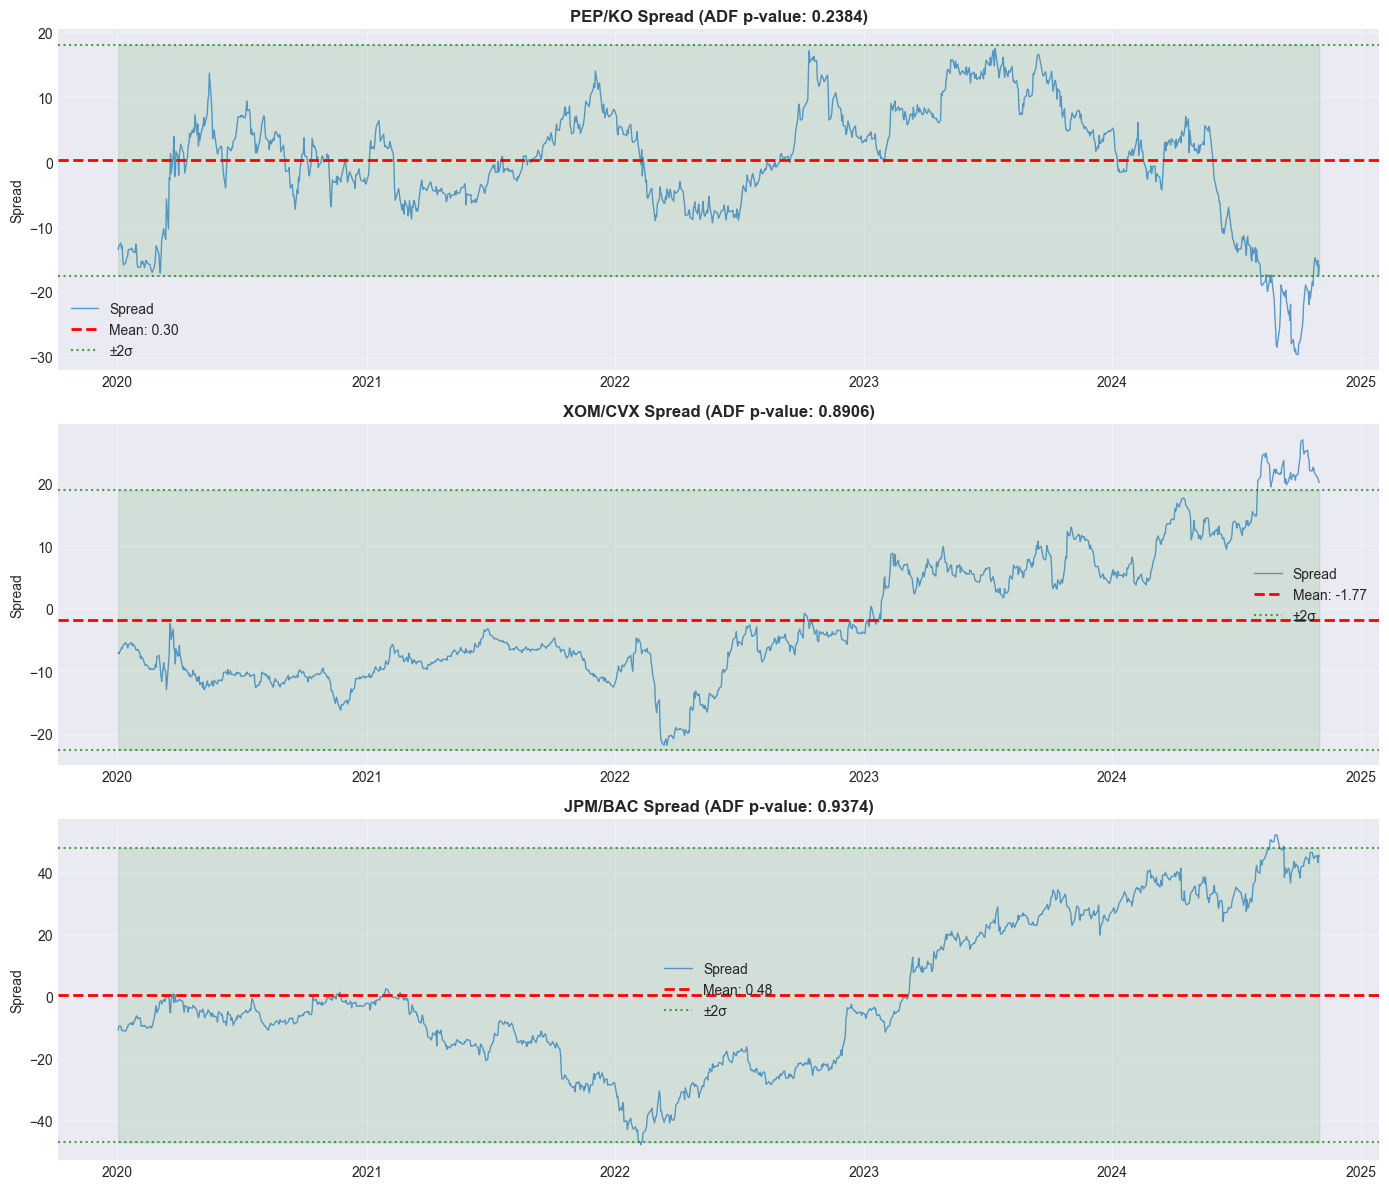

In [4]:
# Visualize spreads
fig, axes = plt.subplots(len(pairs), 1, figsize=(14, 4*len(pairs)))

for idx, result in enumerate(results):
    ax = axes[idx] if len(pairs) > 1 else axes
    spread = result['Spread']
    
    # Plot spread
    ax.plot(spread.index, spread.values, linewidth=1, alpha=0.7, label='Spread')
    
    # Plot mean and std bands
    mean = spread.mean()
    std = spread.std()
    ax.axhline(y=mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    ax.axhline(y=mean + 2*std, color='green', linestyle=':', alpha=0.7, label='±2σ')
    ax.axhline(y=mean - 2*std, color='green', linestyle=':', alpha=0.7)
    ax.fill_between(spread.index, mean - 2*std, mean + 2*std, alpha=0.1, color='green')
    
    ax.set_title(f"{result['Pair']} Spread (ADF p-value: {result['ADF p-value']:.4f})", 
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Spread', fontsize=10)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Fitting OU Process to Real Data

Estimate OU parameters from market data using maximum likelihood.

In [5]:
def estimate_ou_parameters(data, dt=1/252):
    """
    Estimate OU parameters using MLE.
    
    Parameters:
    -----------
    data : array-like
        Time series data
    dt : float
        Time step (default 1/252 for daily data)
    
    Returns:
    --------
    dict : Estimated parameters (theta, mu, sigma, half_life)
    """
    data = np.array(data)
    n = len(data)
    
    # Calculate increments
    X = data[:-1]
    dX = np.diff(data)
    
    # MLE estimates
    # From dX = theta(mu - X)dt + sigma*dW
    # Rearrange: dX = -theta*X*dt + theta*mu*dt + sigma*dW
    
    Sx = np.sum(X)
    Sy = np.sum(dX)
    Sxx = np.sum(X * X)
    Sxy = np.sum(X * dX)
    
    # theta and mu estimates
    theta = -(Sxy * n - Sx * Sy) / (Sxx * n - Sx * Sx) / dt
    mu = (Sy + theta * Sx * dt) / (n * theta * dt)
    
    # sigma estimate
    residuals = dX - theta * (mu - X) * dt
    sigma = np.sqrt(np.sum(residuals**2) / n / dt)
    
    # Calculate half-life
    half_life = np.log(2) / theta if theta > 0 else np.inf
    
    return {
        'theta': theta,
        'mu': mu,
        'sigma': sigma,
        'half_life': half_life,
        'half_life_days': half_life * 252  # Convert to trading days
    }

# Estimate parameters for each spread
print("\nOU PARAMETER ESTIMATES FOR SPREADS")
print("="*80)

for result in results:
    spread = result['Spread']
    params = estimate_ou_parameters(spread.values)
    
    print(f"\n{result['Pair']}:")
    print(f"  θ (mean reversion speed): {params['theta']:.6f}")
    print(f"  μ (long-term mean):       {params['mu']:.4f}")
    print(f"  σ (volatility):           {params['sigma']:.4f}")
    print(f"  Half-life:                {params['half_life_days']:.2f} trading days")
    print(f"  Stationary:               {result['Stationary']}")
    
    result['ou_params'] = params


OU PARAMETER ESTIMATES FOR SPREADS

PEP/KO:
  θ (mean reversion speed): 2.396465
  μ (long-term mean):       0.1063
  σ (volatility):           19.8018
  Half-life:                72.89 trading days
  Stationary:               No

XOM/CVX:
  θ (mean reversion speed): 0.276418
  μ (long-term mean):       18.5182
  σ (volatility):           12.3694
  Half-life:                631.92 trading days
  Stationary:               No

JPM/BAC:
  θ (mean reversion speed): 0.088965
  μ (long-term mean):       130.4554
  σ (volatility):           22.0574
  Half-life:                1963.39 trading days
  Stationary:               No


## 4. Pairs Trading Strategy

Implement a simple mean-reversion trading strategy.


Backtesting PEP/KO (most stationary)...

Backtest Results:
  Total Trades: 9
  Final P&L (z-score units): 5.9094
  Average P&L per trade: 0.6566


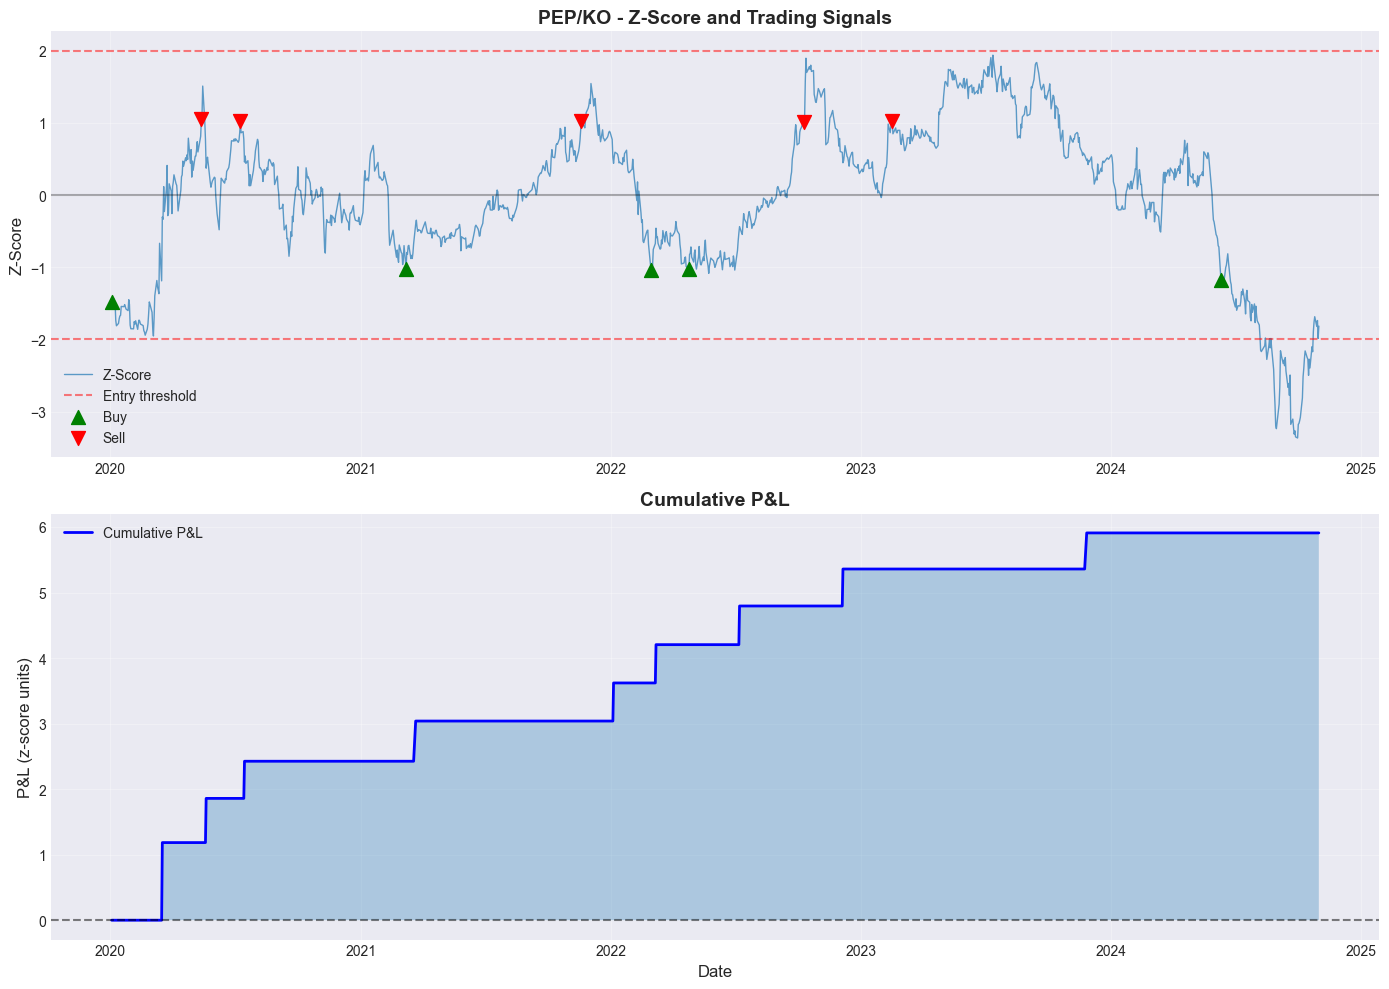

In [6]:
def backtest_pairs_strategy(spread, entry_threshold=1.0, exit_threshold=0.5, stop_loss=3.0):
    """
    Backtest mean reversion pairs trading strategy.
    
    Parameters:
    -----------
    spread : pd.Series
        Normalized spread (z-score)
    entry_threshold : float
        Number of std devs to trigger entry
    exit_threshold : float
        Number of std devs to close position
    stop_loss : float
        Number of std devs for stop loss
    
    Returns:
    --------
    pd.DataFrame : Trading signals and P&L
    """
    # Calculate z-score
    z_score = (spread - spread.mean()) / spread.std()
    
    # Initialize
    position = 0  # 0: no position, 1: long spread, -1: short spread
    signals = []
    pnl = [0]
    cumulative_pnl = 0
    
    for i in range(1, len(z_score)):
        z = z_score.iloc[i]
        z_prev = z_score.iloc[i-1]
        
        # Trading logic
        if position == 0:
            if z < -entry_threshold:
                position = 1  # Long spread (buy stock1, sell stock2)
                entry_price = z
                signals.append('BUY')
            elif z > entry_threshold:
                position = -1  # Short spread
                entry_price = z
                signals.append('SELL')
            else:
                signals.append('HOLD')
        
        elif position == 1:  # Currently long
            if z > -exit_threshold or z > stop_loss:
                pnl_trade = z - entry_price
                cumulative_pnl += pnl_trade
                position = 0
                signals.append('CLOSE_LONG')
            else:
                signals.append('HOLD_LONG')
        
        elif position == -1:  # Currently short
            if z < exit_threshold or z < -stop_loss:
                pnl_trade = entry_price - z
                cumulative_pnl += pnl_trade
                position = 0
                signals.append('CLOSE_SHORT')
            else:
                signals.append('HOLD_SHORT')
        
        pnl.append(cumulative_pnl)
    
    results_df = pd.DataFrame({
        'z_score': z_score.iloc[1:].values,
        'signal': signals,
        'cumulative_pnl': pnl[1:]
    }, index=spread.index[1:])
    
    return results_df

# Backtest best pair (lowest ADF p-value)
best_pair = min(results, key=lambda x: x['ADF p-value'])
print(f"\nBacktesting {best_pair['Pair']} (most stationary)...")

backtest_results = backtest_pairs_strategy(best_pair['Spread'])

# Calculate metrics
total_trades = len(backtest_results[backtest_results['signal'].str.contains('CLOSE')])
final_pnl = backtest_results['cumulative_pnl'].iloc[-1]

print(f"\nBacktest Results:")
print(f"  Total Trades: {total_trades}")
print(f"  Final P&L (z-score units): {final_pnl:.4f}")
print(f"  Average P&L per trade: {final_pnl/total_trades if total_trades > 0 else 0:.4f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Z-score with signals
ax1.plot(backtest_results.index, backtest_results['z_score'], linewidth=1, alpha=0.7, label='Z-Score')
ax1.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='Entry threshold')
ax1.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Mark trades
buy_signals = backtest_results[backtest_results['signal'] == 'BUY']
sell_signals = backtest_results[backtest_results['signal'] == 'SELL']
ax1.scatter(buy_signals.index, buy_signals['z_score'], color='green', marker='^', s=100, label='Buy', zorder=5)
ax1.scatter(sell_signals.index, sell_signals['z_score'], color='red', marker='v', s=100, label='Sell', zorder=5)

ax1.set_title(f'{best_pair["Pair"]} - Z-Score and Trading Signals', fontsize=14, fontweight='bold')
ax1.set_ylabel('Z-Score', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative P&L
ax2.plot(backtest_results.index, backtest_results['cumulative_pnl'], linewidth=2, color='blue', label='Cumulative P&L')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(backtest_results.index, backtest_results['cumulative_pnl'], 0, alpha=0.3)
ax2.set_title('Cumulative P&L', fontsize=14, fontweight='bold')
ax2.set_ylabel('P&L (z-score units)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **OU Process**: Models mean reversion with speed θ and long-term mean μ
2. **Stationarity**: Test with ADF; p-value < 0.05 indicates mean reversion
3. **Cointegration**: Related stocks may have cointegrated prices (stationary spread)
4. **Half-Life**: Measures time for mean reversion (shorter = faster)
5. **Pairs Trading**: Exploits mean reversion by trading spread deviations
6. **Real Data**: Not all pairs are cointegrated; careful selection crucial

## 📝 Guided Exercises with Auto-Validation

Test your understanding of mean reversion and OU processes!

### Exercise 1: OU Process Properties (Beginner)

Verify properties of the Ornstein-Uhlenbeck process.

In [8]:
# Exercise 1: OU Process Half-Life
import numpy as np

# Given OU process parameters
theta = 0.5  # Mean reversion speed
mu = 10.0    # Long-term mean
sigma = 2.0  # Volatility

# TODO: Calculate the half-life of mean reversion
# Formula: half_life = ln(2) / theta
half_life = np.log(2) / theta

# TODO: Calculate the stationary variance
# Formula: stationary_variance = sigma^2 / (2 * theta)
stationary_variance = sigma**2 / (2 * theta)
# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert half_life is not None, "❌ Calculate the half-life!"
assert stationary_variance is not None, "❌ Calculate stationary variance!"
expected_half_life = np.log(2) / theta
assert np.isclose(half_life, expected_half_life, rtol=0.01), f"❌ Half-life incorrect. Expected {expected_half_life:.3f}, got {half_life:.3f}"
expected_var = sigma**2 / (2 * theta)
assert np.isclose(stationary_variance, expected_var, rtol=0.01), f"❌ Variance incorrect. Expected {expected_var:.3f}, got {stationary_variance:.3f}"
print("✅ Exercise 1 Complete!")
print(f"   Half-life: {half_life:.3f} time units")
print(f"   Stationary Variance: {stationary_variance:.3f}")
print(f"   Interpretation: Process reverts halfway to mean in {half_life:.2f} units")
# =========================================================

✅ Exercise 1 Complete!
   Half-life: 1.386 time units
   Stationary Variance: 4.000
   Interpretation: Process reverts halfway to mean in 1.39 units
